# Loading Imagenette using Batcher

In [ ]:
%install-location $cwd/swift-install
%install-swiftpm-flags -c release
%install '.package(url: "https://github.com/tensorflow/swift-models", .branch("master"))' Batcher ModelSupport Datasets

In [2]:
import TensorFlow
import Batcher
import Foundation
import ModelSupport
import Datasets

## Downloading the data

First thing first, we will need to download the data somewhere. We use `DatasetUtilities` for this. You just need to split the url where the archived file is between the filename, extension and rest of the host url, then specify the folder where you want it downloaded. The function `.downloadResource` will then automatically download the archive (if needed) and inflate it (in the process the folder you specified will be created if it didn't exist).

In [3]:
let cwdURL = URL(fileURLWithPath: FileManager.default.currentDirectoryPath)
let dataFolder = DatasetUtilities.downloadResource(
    filename: "imagenette2", 
    fileExtension: "tgz",
    remoteRoot: URL(string: "https://s3.amazonaws.com/fast-ai-imageclas/")!,
    localStorageDirectory: cwdURL.appendingPathComponent("data/", isDirectory: true)
)

Loading resource: imagenette2


Then we can collect all jpeg files inside that directory with `collectURLs`:

In [4]:
let urls = collectURLs(under: dataFolder, recurse: true, filtering: ["jpeg"])
urls.count

13394


The filename urls we gathered look like this:

In [5]:
urls[0]

▿ file:///home/sgugger/notebooks/swift/data/imagenette2/val/n03425413/n03425413_12962.JPEG
  ▿ _storage : Optional<Storage>
    ▿ some : Storage
      ▿ boxedRequiresCopyOnWrite : <URLBox: 0x1c9b7a0>


So we have a nested-folder structure, with a training and a validation folder, then one folder per class. Those classes have bizare names that come from word2vec, we will change them into something readable a little bit later. 

To split our filenames between training and validation set, we need to look at the grandparent folder, so we will use this function:

In [6]:
public func grandParentSplitter(urls: [URL], trainName: String = "train", validName: String = "valid") 
-> ([URL], [URL]) {
    return (urls.filter() { $0.pathComponents[$0.pathComponents.count - 3] == trainName },
            urls.filter() { $0.pathComponents[$0.pathComponents.count - 3] == validName })
}

In [7]:
let (trainUrls, validUrls) = grandParentSplitter(urls: urls, validName: "val")
(trainUrls.count, validUrls.count)

▿ 2 elements
  - .0 : 9469
  - .1 : 3925


## A first look at our data

### Opening the images

First things first, let's load one of those images and look at it. We use the python interop and matplotlib for this:

In [8]:
//For image show
import Python
let plt = Python.import("matplotlib.pyplot")

In [9]:
//Special notebook magic, do not copy outside of Jupyter
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


We need to use some `_Raw` functions to open those iamges for now. We hope in the future to have something independent of that (note that you could use some other package than `TensorFlow` to open them, like `SwiftCV`, that wraps openCV in swift). 

In [10]:
func openImage(url: URL) -> Tensor<UInt8> {
    let loadedFile = _Raw.readFile(filename: StringTensor(url.absoluteString))
    return _Raw.decodeJpeg(contents: loadedFile, channels: 3, dctMethod: "")
}

Now we can use this to open one image and look at it. 

In [11]:
let image = openImage(url: trainUrls[0])

In [12]:
func oneAxes() -> PythonObject {
    plt.figure()
    return plt.subplot(1, 1, 1)
}

In [13]:
func showTensorImage<S> (_ image: Tensor<S>, title: String? = nil, pltAxes: PythonObject? = nil) where S: NumpyScalarCompatible {
    let numpyImage = image.makeNumpyArray()
    let axes = pltAxes ?? oneAxes()
    axes.imshow(numpyImage) 
    axes.axis("off")
    if title != nil { axes.set_title(title!) } 
    if pltAxes == nil { plt.show() }
}

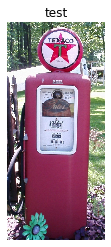

In [14]:
showTensorImage(image, title: "test")

### Getting the labels

From the structure we saw before, labels are given by the name of the parent folder. We can then easily:
- grab all labels on the training set
- make sure we remove all duplicates
- create a reverse map label to index since our model will want numbers

In [15]:
let allLabels = trainUrls.map { $0.pathComponents[$0.pathComponents.count - 2] }
let labels = Array(Set(allLabels)).sorted()
let labelToInt = Dictionary(uniqueKeysWithValues: labels.enumerated().map{ ($0.element, $0.offset) })
print(labelToInt)

["n02102040": 1, "n03425413": 7, "n03417042": 6, "n03445777": 8, "n03000684": 3, "n02979186": 2, "n01440764": 0, "n03028079": 4, "n03888257": 9, "n03394916": 5]


### Together in a `TensorPair`

A `TensorPair` is just a structure containing two tensors, one for the input and one for the label. We can easily create a `TensorPair` from one filename like this:

In [16]:
func createSample(url: URL) -> TensorPair<UInt8, Int32> {
    let image = openImage(url: url)fi
    let label = url.pathComponents[url.pathComponents.count - 2]
    return TensorPair(first: image, second: Tensor<Int32>(Int32(labelToInt[label]!)))
}

Before looking at our samples, let's fix those labels and convert them to English.

In [17]:
let labelNames = [
    "n01440764":"tench",
    "n02102040":"English springer",
    "n02979186":"cassette player",
    "n03000684":"chain saw",
    "n03028079":"church",
    "n03394916":"French horn",
    "n03417042":"garbage truck",
    "n03425413":"gas pump",
    "n03445777":"golf ball",
    "n03888257":"parachute"
]

Now the following function shows one sample:

In [18]:
func showSample(_ sample: TensorPair<UInt8, Int32>, pltAxes: PythonObject? = nil) {
    let title = labelNames[labels[Int(sample.second.scalarized())]]
    showTensorImage(sample.first, title: title, pltAxes: pltAxes)
}

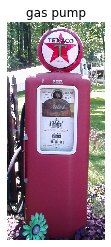

In [19]:
showSample(createSample(url: trainUrls[0]))

And this one show a bunch of them:

In [20]:
func showSamples(_ samples: [TensorPair<UInt8, Int32>], figureSize: [Int]? = nil) {
    let rows = Int(sqrt(Double(samples.count)))
    let cols = samples.count / rows + (samples.count % rows == 0 ? 0 : 1)
    plt.figure(figsize: figureSize ?? [cols*3, rows*3])
    let axes = Array(1...samples.count).map { plt.subplot(rows, cols, $0) }
    for (sample,ax) in zip(samples, axes) {
        showSample(sample, pltAxes: ax)
    }
    plt.show()
}

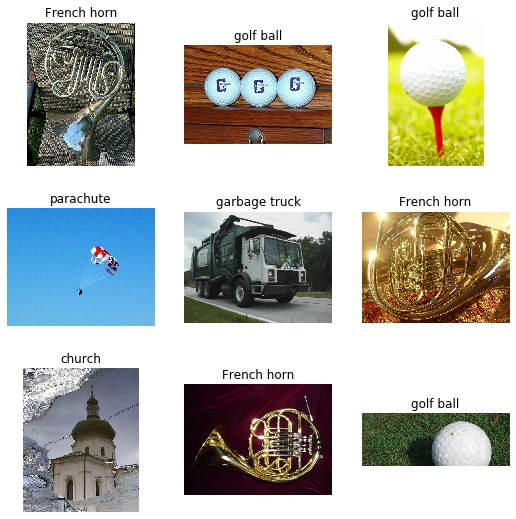

In [21]:
showSamples(trainUrls.shuffled()[..<9].map { createSample(url: $0) })

## Apply some data augmentation

We could just resize every image in the `openImage` function and be done, but an efficient training requires a bit of data augmentation. The usual data augmentation technique used on ImageNet is a random resized crop followed by a random flip.

### RandomResizedCrop

This data augmentation technique consists in picking a random area of the image, crop to it then resize that area (usually a rectangle) to a square (usually of 224 by 244 pixels). To do this it randomly picks:
- the scale (between a given parameter `minScale` and `1`) and multiplies it by the total area of the picture (width multiplied by height)
- an aspect ratio (between the bounds given by a tuple as a parameter), that it uses to build a cropping width and height
- a random location inside the image for this crop

Then it resizes that crop to the final desired size. Since all combinations of random scales and aspect ratios do not necessarily lead to a cropped size that is inside the image, we make a few attempts before falling backing to a regular resize.

In [27]:
public struct RandomResizedCrop {
    public let minScale: Float
    public let ratioRange: (Float, Float)
    public let size: Int
    
    public init(to size: Int, minScale: Float = 0.35, ratioRange: (Float, Float) = (3.0/4.0, 4.0/3.0)) {
        self.size = size
        self.minScale = minScale
        self.ratioRange = ratioRange
    }
    
    public func callAsFunction(_ x: Tensor<UInt8>) -> Tensor<UInt8> {
        let (height, width) = (x.shape[0], x.shape[1])
        for _ in 0..<10 {
            let area = Float.random(in: minScale...1.0) * Float(width * height)
            let ratio = exp(Float.random(in: log(ratioRange.0)...log(ratioRange.1)))
            let croppedWidth = Int(round(sqrt(area * ratio)))
            let croppedHeight = Int(round(sqrt(area / ratio)))
            if croppedWidth < width && croppedHeight < height {
                let topCorner = Int32(Int.random(in: 0...(height - croppedHeight)))
                let leftCorner = Int32(Int.random(in: 0...(width - croppedWidth)))
                let crop = x.slice(
                    lowerBounds: Tensor<Int32>([topCorner, leftCorner, 0]), 
                    sizes: Tensor<Int32>([Int32(croppedHeight), Int32(croppedWidth), 3])
                )
                let resized = _Raw.resizeBilinear(
                    images: Tensor<UInt8>([crop]), 
                    size: Tensor<Int32>([Int32(size), Int32(size)]))[0]
                return Tensor<UInt8>(resized)
            }
        }
        let resized = _Raw.resizeBilinear(
            images: Tensor<UInt8>([x]), 
            size: Tensor<Int32>([Int32(size), Int32(size)]))[0]
        return Tensor<UInt8>(resized)
    }
    
    public func callAsFunction(_ x: TensorPair<UInt8, Int32>) -> TensorPair<UInt8, Int32> {
        return TensorPair(first: callAsFunction(x.first), second: x.second)
    }
}

Let's see some examples on an image of the training set (the image on the top left is the original):

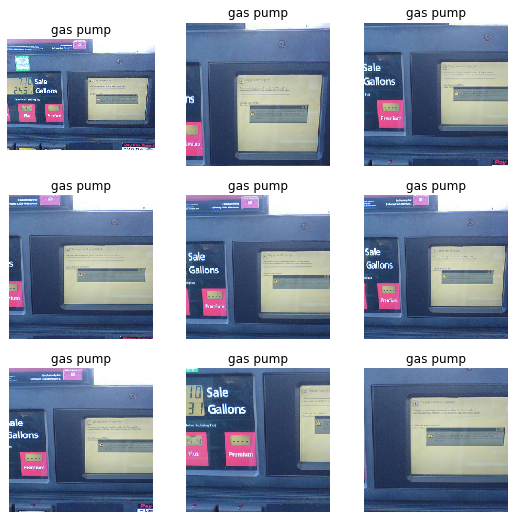

In [28]:
let sample = createSample(url: trainUrls[1])
let rrc = RandomResizedCrop(to: 224)
var examples: [TensorPair<UInt8, Int32>] = [sample] 
for _ in 1..<9 { examples.append(rrc(sample)) }
showSamples(examples)

### Random flip

This data augmentation technique just consists in randomly flipping horizontally, usually with probability 0.5.

In [29]:
public struct RandomFlip {
    public let p: Float
    
    public init(p: Float = 0.5) {
        self.p = p
    }
    
    public func callAsFunction(_ x: Tensor<UInt8>) -> Tensor<UInt8> {
        let draw = Float.random(in: 0.0...1.0)
        return  draw < self.p ? _Raw.reverse(x, dims: Tensor<Bool>([false, true, false])) : x
    }
    
    public func callAsFunction(_ x: TensorPair<UInt8, Int32>) -> TensorPair<UInt8, Int32> {
        return TensorPair(first: callAsFunction(x.first), second: x.second)
    }
}

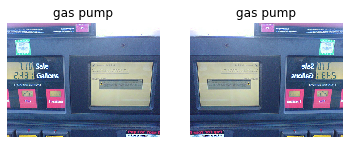

In [30]:
examples = [sample, RandomFlip(p: 1.0)(sample)]
showSamples(examples)

### Regular resize

For the validation set, we won't apply random resized crop, but a regular resize.

In [31]:
public struct Resize {
    public let size: Int
    
    public init(to size: Int) {
        self.size = size
    }
    
    public func callAsFunction(_ x: Tensor<UInt8>) -> Tensor<UInt8> {
        let resized = _Raw.resizeBilinear(
            images: Tensor<UInt8>([x]), 
            size: Tensor<Int32>([Int32(size), Int32(size)]))[0]
        return Tensor<UInt8>(resized)
    }
    
    public func callAsFunction(_ x: TensorPair<UInt8, Int32>) -> TensorPair<UInt8, Int32> {
        return TensorPair(first: callAsFunction(x.first), second: x.second)
    }
}

## Create a `Batcher`

### Lazy dataset

To create a `Batcher` (which will gather the data lazily using multiprocessing and collate it in batches ready to feed to a model) we just need to lazily apply the transforms we built on the training and validation lists of filenames. For this, there is .lazy.map.

In [32]:
let randomFlip = RandomFlip()
let randomResizedCrop = RandomResizedCrop(to: 224)
let trainingSet = trainUrls.lazy.map {
    return randomFlip(randomResizedCrop(createSample(url: $0)))
}

In [33]:
let resize = Resize(to: 224)
let validationgSet = validUrls.lazy.map {
    return resize(createSample(url: $0))
}

Then we can pass this along to `Batcher` and we will almost be done!

In [34]:
let trainBatcher = Batcher(on: trainingSet, batchSize: 64, numWorkers: 8, shuffle: true, dropLast: true)
let validBatcher = Batcher(on: validationgSet, batchSize: 64, numWorkers: 8)

We can now iterate though our batches with `trainBatcher.sequenced` or `validationBatcher.sequenced`. The last piece missing is that we still have tensor of UInt8s for the input, and we need to normalize.

### Batch transforms

First we convert to float and divide the inputs by 255:

In [35]:
public func toFloat(_ b: TensorPair<UInt8, Int32>) -> TensorPair<Float, Int32> {
    return TensorPair(first: Tensor<Float>(b.first)/225.0, second: b.second)
}

Then we normalize with some mean and std:

In [36]:
public struct Normalizer {
    public let mean: Tensor<Float>
    public let std: Tensor<Float>
    
    public init(mean: Tensor<Float>, std: Tensor<Float>) {
        (self.mean, self.std) = (mean, std)
    }
    
    public init(mean: Tensor<Float>, std: Tensor<Float>, expandingShapeAt: [Int], eps: Float = 1e-7) {
        self.mean = mean.expandingShape(at: expandingShapeAt)
        self.std  = std.expandingShape(at: expandingShapeAt) + eps
    }
    
    public func callAsFunction(_ x: TensorPair<Float, Int32>) -> TensorPair<Float, Int32> {
        return TensorPair(first: (x.first - mean) / std, second: x.second)
    }
    
    public func denormalize<S: TensorFlowScalar>(_ x: TensorPair<Float,S>) -> TensorPair<Float,S> {
        return TensorPair(first: (x.first * std) + mean, second: x.second)
    }
}

We can then define one with the ImageNet statistics:

In [37]:
public let imageNetNormalizer = Normalizer(
    mean: Tensor<Float>([0.485, 0.456, 0.406]),
    std:  Tensor<Float>([0.229, 0.224, 0.225]),
    expandingShapeAt: [0,1,2]
)

So here are our batch transforms:

In [38]:
let batchTransforms : (TensorPair<UInt8, Int32>) -> TensorPair<Float, Int32> = { imageNetNormalizer(toFloat($0)) }

To iterate through our batches and apply those, we just use `.lazy.map` again:

In [39]:
for b in trainBatcher.sequenced().lazy.map(batchTransforms) {
    //Put the training loop here
    let x = b.first.shape
}

## Training loop

Coming soon!